In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from cvxopt import matrix, solvers

In [11]:
def dataset(cls1,cls2):
  x1,y1 = cls1.T
  x2,y2 = cls2.T
  X = np.vstack((cls1,cls2))
  print(X.shape)
  y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape(2*N,)
  print(y.shape)
  #print(X,"\n",y)
  return x1,y1,x2,y2,X,y

In [12]:
def Duality(cls1,cls2,data):   #Quadratic Programming
  
  V = np.concatenate((cls1.T, -cls2.T), axis =1 ) #[y1x1 , y2x2 ,... ynxn]
  print('V = ',V.shape)
  K = matrix(V.T.dot(V))
  print('K = ',K.size)
  p = matrix(-np.ones((2*N,1)))
  print('p = ',p.size)
  G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))  #sparse matrix for lambda
  print('G = ',G.size)
  h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))  #G*lambda <= h 
  print('h = ', h.size)
  A = matrix(data[5].reshape((-1, 2*N)))
  print(data[5].shape)
  print('A = ',A.size)
  b = matrix(np.zeros((1, 1)))
  
  solvers.options['show_progress'] = False
  sol = solvers.qp(K, p, G, h, A, b)
  l = np.array(sol['x'])  #lambda result

  #print('lambda = ',l.T) #1x2N matrix
  return V,l

In [13]:
def sp_vector(data,dl):
  e = 1e-4
  S = np.where(dl[1] > e)[0]  # if lambda > e then return position of lambda in array
  S2 = np.where(dl[1] < .999*C)[0]
  print(S)
  M = [val for val in S if val in S2]
  XT = data[4].T
  Vs = dl[0][:,S] #returns the value in array V at column S
  ls = dl[1][S] #return value lambda > e
  yM = data[5][M]
  XM = XT[:,M]

  w = Vs.dot(ls).reshape(-1,1)
  b = np.mean(yM.T - w.T.dot(XM))

  print("w = ", w.T)
  print("b = ", b)
  return w,b

In [14]:
def decision_boundary(vector):
  w = vector[0]
  b = vector[1]
  # wT*X +b =0 
  # w1*x + w2*y + b =0 
  x = np.linspace(-15,15,1000)
  y = -w[0]/w[1]*x - b/w[1]
  y1 = -w[0]/w[1]*x - (b-1)/w[1]
  y2 = -w[0]/w[1]*x - (b+1)/w[1]
  return x,y,y1,y2,-w[0]/w[1],b/w[1]

In [15]:
def classification(cls1,cls2,db):
    TP = 0  #True Positives
    TN = 0  #True Negatives
    FP = 0  #False Positives
    FN = 0  #False Negatives
    x1,y1 = cls1.T
    x2,y2 =cls2.T
    a = db[4]
    b = db[5]
    y1_predict = a*x1 - b #a*x1+b
    y2_predict = a*x2 - b
    for i in range(N):
      if y1_predict[i] > y1[i]:
        TP +=1
      else:
        FN +=1
      if y2_predict[i] > y2[i]:
        FP +=1
      else:
        TN +=1
# Calculate accuracy: TP+TN/(TP+TN+FP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    print("Accuracy =%.4f"%accuracy)
# Calculate precision: TP/(TP+FP)
    precision =  TP/(TP+FP)
    print("Precision =%.4f"%precision)
# Calculate Recall : TP/(TP+FN)
    Recall = TP/(TP+FN)
    print("Recall =%.4f"%Recall)
# Calculate F1 score = 2*(Precision * Recall)/(Precision + Recall)
    F1 = 2*(precision * Recall)/(precision + Recall)
    print("F1 Score = %.4f"%F1)
    return x1,y1_predict,x2,y2_predict

In [16]:
C = 100
N = 200
mean = [[-5,-5], [5,5]] #center
cov = [[8,4],[4,8]] #covariance
cls1 = np.random.multivariate_normal(mean[0], cov, N) # each row is a data point 
print(cls1.shape)
cls2 = np.random.multivariate_normal(mean[1], cov, N)
data = dataset(cls1,cls2)
dl = Duality(cls1,cls2,data)
vector = sp_vector(data,dl)
db = decision_boundary(vector)
clf = classification(cls1,cls2,db)

(200, 2)
(400, 2)
(400,)
V =  (2, 400)
K =  (400, 400)
p =  (400, 1)
G =  (800, 400)
h =  (800, 1)
(400,)
A =  (1, 400)
[  5  21  38  86 106 121 145 187 190 217 241 267 327 344 356 371 372 387]
w =  [[-0.48960198 -0.57285217]]
b =  0.6018612806440385
Accuracy =0.9775
Precision =0.9751
Recall =0.9800
F1 Score = 0.9776


In [17]:
# sklearnライブラリを使用して結果を確認する
#1111
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,KFold
clf = SVC(kernel = 'linear', C = 100)
clf.fit(data[4], data[5]) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print('w = ', w_sklearn.T)
print('b = ', b_sklearn)

print('sklearn_score:',clf.score(data[4],data[5]))
kf= KFold(n_splits= 50)  #cross-validation with 50-Fold
score= cross_val_score(clf,data[4],data[5],cv=kf)
print("Cross Validation Scores: {}".format(score))
print("Average Cross Validation score: {}".format(score.mean()))

w =  [[-0.48971839 -0.57313789]]
b =  0.6020558664232291
sklearn_score: 0.9775
Cross Validation Scores: [1.    1.    1.    1.    0.875 1.    1.    1.    1.    1.    1.    1.
 1.    0.875 1.    1.    1.    1.    0.875 1.    1.    1.    1.    0.875
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    0.875 1.    1.    0.875 0.875 1.    0.875 1.
 0.875 1.   ]
Average Cross Validation score: 0.9775


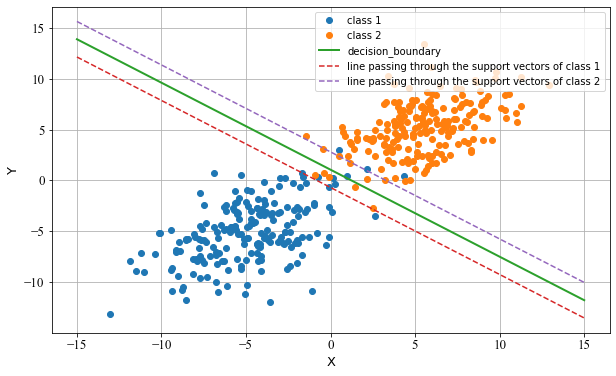

In [18]:
ax = plt.subplot()
plt.rcParams["figure.figsize"] = (10,6)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Times New Roman')
    label.set_fontsize(13)
plt.plot(data[0],data[1],'o',label = "class 1")
plt.plot(data[2],data[3],'o',label = "class 2")
plt.plot(db[0],db[1],label = "decision_boundary", linewidth= 2)
plt.plot(db[0], db[2],'--', label = 'line passing through the support vectors of class 1')
plt.plot(db[0], db[3],'--',label = 'line passing through the support vectors of class 2')
plt.xlabel("X",fontsize = 13)
plt.ylabel("Y",fontsize = 13)
plt.legend()
plt.grid()
plt.show()